# All bands in one model

Cell 1 : Line 117 should be changed

Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))

=== Evaluating Shannon Entropy Features with 10-Fold Cross-Validation ===

=== Classifier Performance (10-fold Accuracy) ===
SVM: 0.450 ± 0.029
Random Forest: 0.420 ± 0.025
Naive Bayes: 0.432 ± 0.024
Logistic Regression: 0.443 ± 0.028
Decision Tree: 0.381 ± 0.030


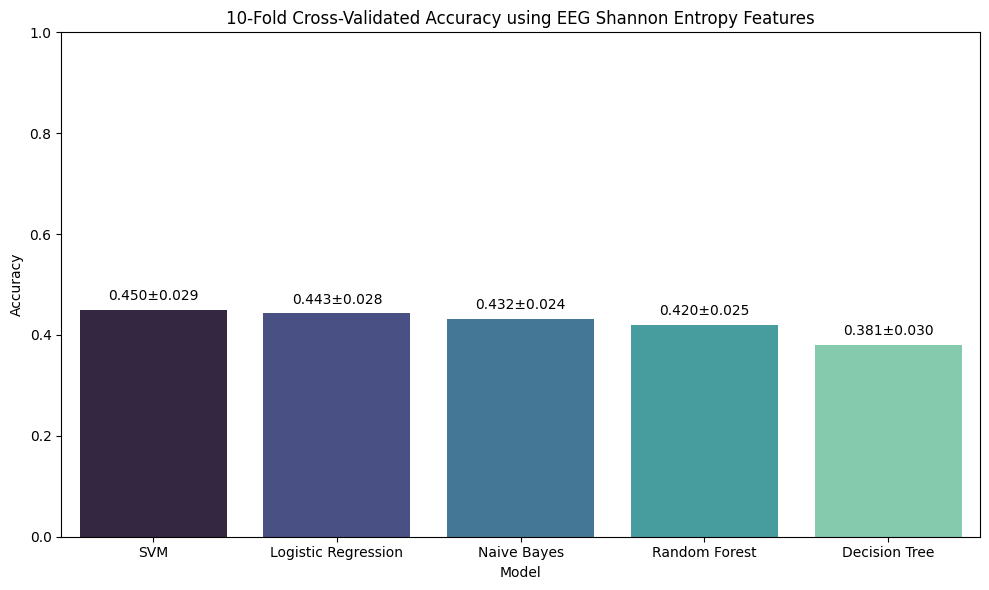

In [1]:
import scipy.io
import os
import numpy as np
import random
from scipy.stats import entropy
from scipy.signal import butter, filtfilt

# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


# ===== SHANNON ENTROPY FEATURE EXTRACTION =====

def compute_shannon_entropy(signal, bins=100):
    """Compute Shannon entropy of a signal (time domain) using histogram binning."""
    histogram, bin_edges = np.histogram(signal, bins=bins, density=True)
    probs = histogram / np.sum(histogram)  # Normalize to get probability distribution
    probs = probs[probs > 0]  # Remove zero entries to avoid log(0)
    return entropy(probs)

def bandpass_filter(signal, lowcut=0.1, highcut=40.0, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def extract_shannon_entropy_features(signal):
    """
    Extract Shannon entropy features from an EEG signal.
    """
    signal = np.array(signal, dtype=np.float64)
    
    # Apply bandpass filter
    filtered_signal = bandpass_filter(signal, fs=200)
    
    # Compute Shannon entropy
    entropy_val = compute_shannon_entropy(filtered_signal)
    return [entropy_val]

def process_data(data_array, feature_function):
    """
    Process data array and extract features from different frequency bands.
    data_array: shape (trials, channels, samples)
    fs: sampling frequency
    feature_function: function to extract features from signal
    """
    bands = {
        "delta": (0.1, 4),
        "theta": (4, 8),
        "alpha": (8, 14),
        "beta": (14, 30),
        "gamma": (30, 40)
    }

    feature_list = []
    for trial_data in data_array:  # Each trial: channels x samples
        # Only use the first channel (channel 0)
        channel_data = trial_data[0, :]  # Get first channel
        trial_features = []
        for band_name, (low, high) in bands.items():
            filtered_signal = bandpass_filter(channel_data, low, high)
            band_features = feature_function(filtered_signal)
            trial_features.append(band_features)
        feature_list.append(np.concatenate(trial_features))
    return np.array(feature_list)


# ===== MACHINE LEARNING PIPELINE =====

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        tol=1e-4,
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# --- Main evaluation function for Shannon entropy features
def evaluate_shannon_entropy_features(data_array, labels_array):
    print("\n=== Evaluating Shannon Entropy Features with 10-Fold Cross-Validation ===")

    # Extract features
    X = process_data(data_array, extract_shannon_entropy_features)

    # Expand labels to match shape of X (one label per trial)
    y = labels_array  # No need to repeat since we have one feature vector per trial
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Prepare cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print("\n=== Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Plot mean accuracies
    accuracy_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Mean Accuracy': [results[m]['Mean Accuracy'] for m in results],
        'Std Accuracy': [results[m]['Std Accuracy'] for m in results]
    }).sort_values(by='Mean Accuracy', ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Model',
        y='Mean Accuracy',
        data=accuracy_df,
        hue='Model',
        palette='mako',
        legend=False
    )

    for p, (_, row) in zip(ax.patches, accuracy_df.iterrows()):
        ax.annotate(f'{row["Mean Accuracy"]:.3f}±{row["Std Accuracy"]:.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.title("10-Fold Cross-Validated Accuracy using EEG Shannon Entropy Features")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return results

# Usage:
results = evaluate_shannon_entropy_features(data_array, labels_array)

# One model for each frequency bands (5 models x 5 bands = 25 total)

Cell 2 : Line 124 should be changed

Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))

EVALUATING EACH FREQUENCY BAND SEPARATELY

=== Evaluating DELTA Band (0.1-4 Hz) ===

=== DELTA Band Classifier Performance (10-fold Accuracy) ===
SVM: 0.412 ± 0.020
Random Forest: 0.354 ± 0.028
Naive Bayes: 0.410 ± 0.026
Logistic Regression: 0.419 ± 0.025
Decision Tree: 0.354 ± 0.026

=== Evaluating THETA Band (4-8 Hz) ===

=== THETA Band Classifier Performance (10-fold Accuracy) ===
SVM: 0.397 ± 0.046
Random Forest: 0.351 ± 0.033
Naive Bayes: 0.380 ± 0.020
Logistic Regression: 0.384 ± 0.025
Decision Tree: 0.351 ± 0.034

=== Evaluating ALPHA Band (8-14 Hz) ===

=== ALPHA Band Classifier Performance (10-fold Accuracy) ===
SVM: 0.381 ± 0.016
Random Forest: 0.336 ± 0.038

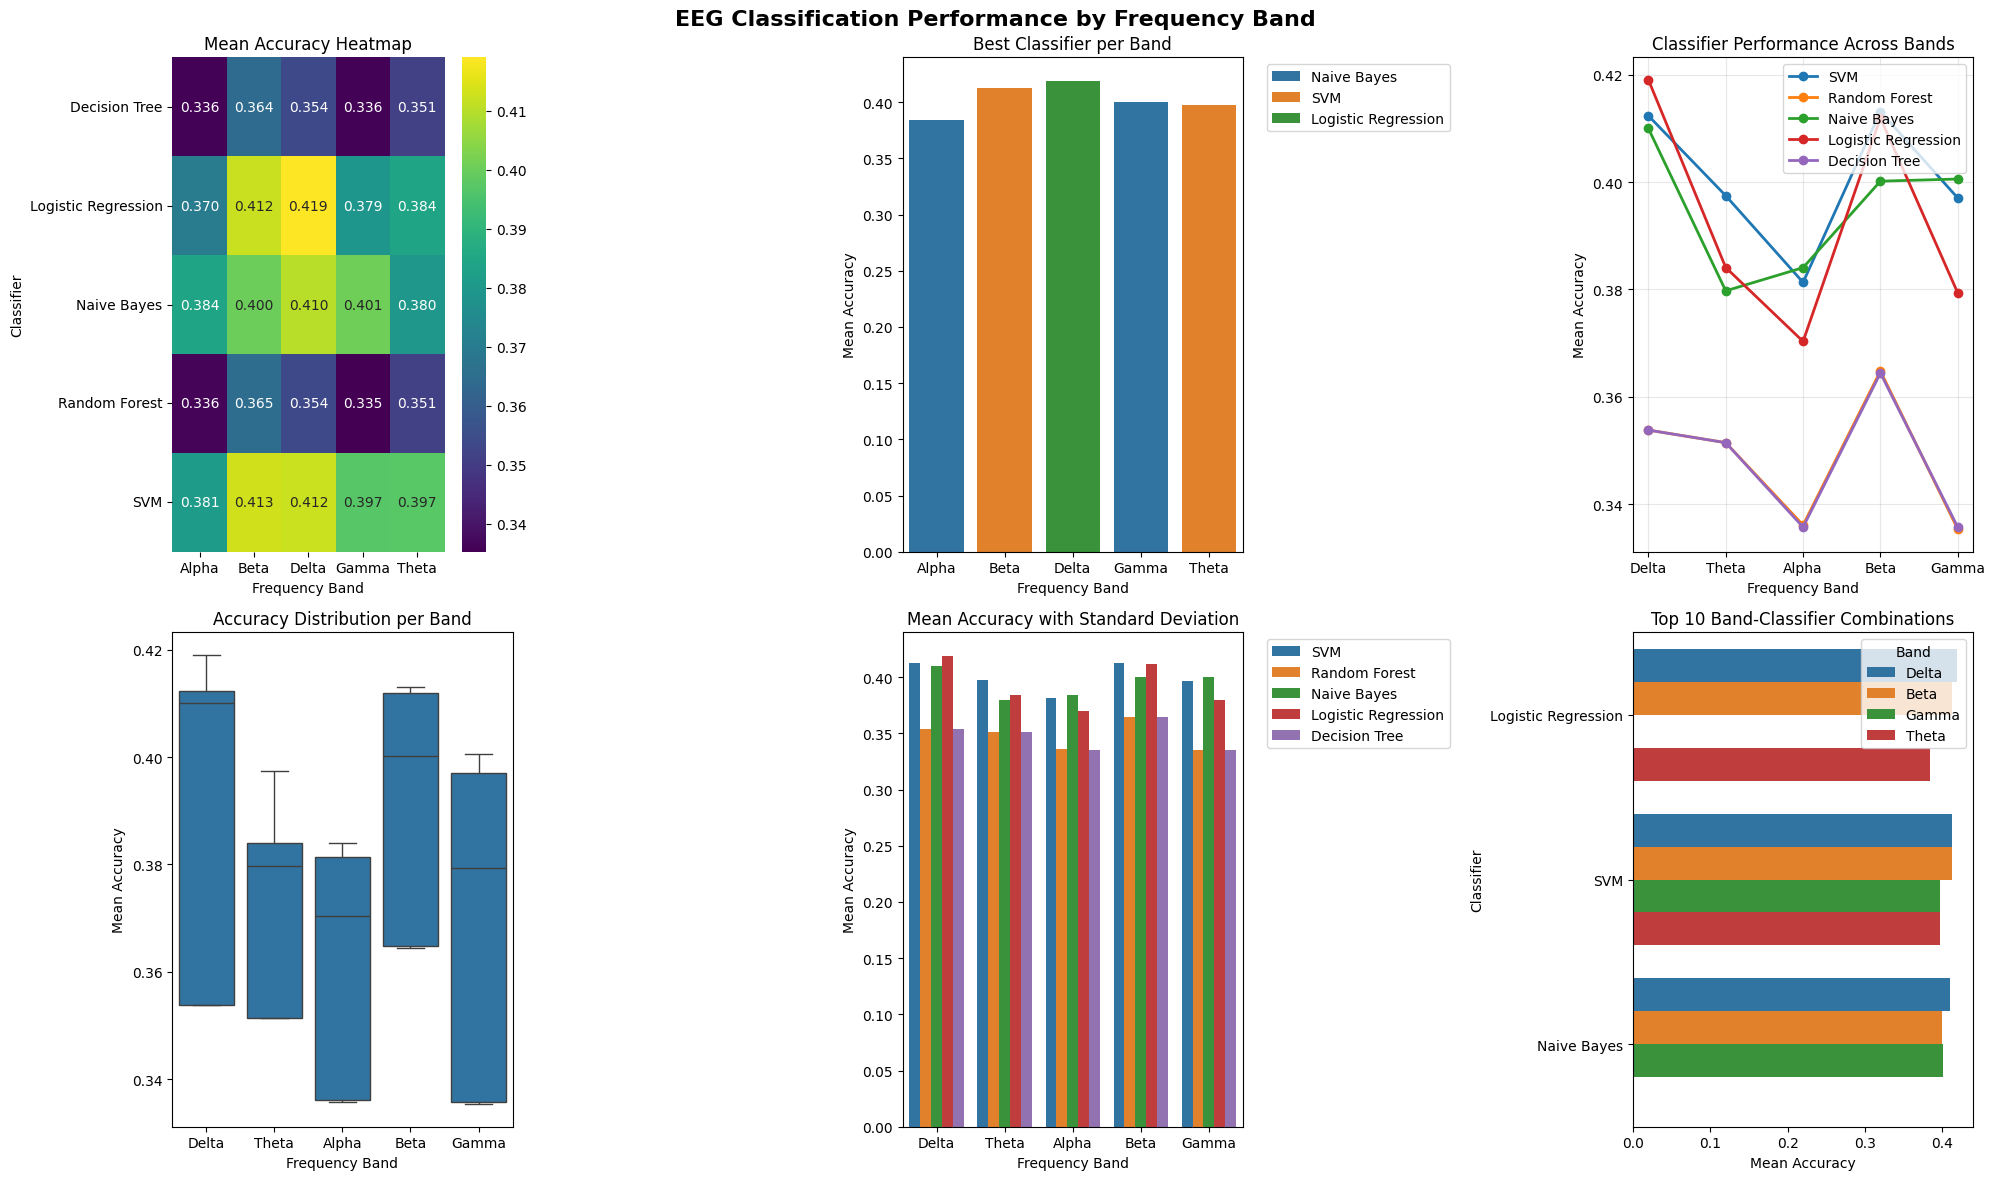


COMPREHENSIVE SUMMARY TABLE
 Band          Classifier Mean Accuracy Std Accuracy   Performance
Delta                 SVM         0.412        0.020 0.412 ± 0.020
Delta       Random Forest         0.354        0.028 0.354 ± 0.028
Delta         Naive Bayes         0.410        0.026 0.410 ± 0.026
Delta Logistic Regression         0.419        0.025 0.419 ± 0.025
Delta       Decision Tree         0.354        0.026 0.354 ± 0.026
Theta                 SVM         0.397        0.046 0.397 ± 0.046
Theta       Random Forest         0.351        0.033 0.351 ± 0.033
Theta         Naive Bayes         0.380        0.020 0.380 ± 0.020
Theta Logistic Regression         0.384        0.025 0.384 ± 0.025
Theta       Decision Tree         0.351        0.034 0.351 ± 0.034
Alpha                 SVM         0.381        0.016 0.381 ± 0.016
Alpha       Random Forest         0.336        0.038 0.336 ± 0.038
Alpha         Naive Bayes         0.384        0.018 0.384 ± 0.018
Alpha Logistic Regression        

In [1]:
import scipy.io
import os
import numpy as np
import random
from scipy.stats import entropy
from scipy.signal import butter, filtfilt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


# ===== SHANNON ENTROPY FEATURE EXTRACTION =====

def compute_shannon_entropy(signal, bins=100):
    """Compute Shannon entropy of a signal (time domain) using histogram binning."""
    histogram, bin_edges = np.histogram(signal, bins=bins, density=True)
    probs = histogram / np.sum(histogram)  # Normalize to get probability distribution
    probs = probs[probs > 0]  # Remove zero entries to avoid log(0)
    return entropy(probs)

def bandpass_filter(signal, lowcut=0.1, highcut=40.0, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def extract_shannon_entropy_features(signal):
    """
    Extract Shannon entropy features from an EEG signal.
    """
    signal = np.array(signal, dtype=np.float64)
    
    # Apply bandpass filter (will be done per band in the new approach)
    filtered_signal = bandpass_filter(signal, fs=200)
    
    # Compute Shannon entropy
    entropy_val = compute_shannon_entropy(filtered_signal)
    return [entropy_val]

def process_data_single_band(data_array, band_range, feature_function):
    """
    Process data array and extract features from a single frequency band.
    data_array: shape (trials, channels, samples)
    band_range: tuple (low_freq, high_freq)
    feature_function: function to extract features from signal
    """
    low_freq, high_freq = band_range
    
    feature_list = []
    for trial_data in data_array:  # Each trial: channels x samples
        # Only use the first channel (channel 0)
        channel_data = trial_data[0, :]  # Get first channel
        
        # Filter for the specific band
        filtered_signal = bandpass_filter(channel_data, low_freq, high_freq)
        
        # Extract features
        trial_features = feature_function(filtered_signal)
        feature_list.append(trial_features)
    
    return np.array(feature_list)


# ===== MACHINE LEARNING PIPELINE =====

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        tol=1e-4,
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Define frequency bands
bands = {
    "delta": (0.1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (30, 40)
}

def evaluate_single_band(data_array, labels_array, band_name, band_range):
    """
    Evaluate classifiers on a single frequency band.
    """
    print(f"\n=== Evaluating {band_name.upper()} Band ({band_range[0]}-{band_range[1]} Hz) ===")

    # Extract features for this specific band
    X = process_data_single_band(data_array, band_range, extract_shannon_entropy_features)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels_array)

    # Prepare cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print(f"\n=== {band_name.upper()} Band Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    return results

def evaluate_all_bands_separately(data_array, labels_array):
    """
    Evaluate all frequency bands separately and create comprehensive visualizations.
    """
    print("\n" + "="*80)
    print("EVALUATING EACH FREQUENCY BAND SEPARATELY")
    print("="*80)
    
    all_results = {}
    
    # Evaluate each band separately
    for band_name, band_range in bands.items():
        band_results = evaluate_single_band(data_array, labels_array, band_name, band_range)
        all_results[band_name] = band_results
    
    # Create comprehensive visualization
    create_band_comparison_plots(all_results)
    
    # Print summary table
    create_summary_table(all_results)
    
    return all_results

def create_band_comparison_plots(all_results):
    """
    Create comprehensive plots comparing performance across bands and classifiers.
    """
    # Prepare data for plotting
    plot_data = []
    for band_name, band_results in all_results.items():
        for classifier_name, metrics in band_results.items():
            plot_data.append({
                'Band': band_name.capitalize(),
                'Classifier': classifier_name,
                'Mean Accuracy': metrics['Mean Accuracy'],
                'Std Accuracy': metrics['Std Accuracy']
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('EEG Classification Performance by Frequency Band', fontsize=16, fontweight='bold')
    
    # Plot 1: Heatmap of mean accuracies
    pivot_df = df.pivot(index='Classifier', columns='Band', values='Mean Accuracy')
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,0])
    axes[0,0].set_title('Mean Accuracy Heatmap')
    axes[0,0].set_xlabel('Frequency Band')
    axes[0,0].set_ylabel('Classifier')
    
    # Plot 2: Bar plot comparing best classifier per band
    best_per_band = df.loc[df.groupby('Band')['Mean Accuracy'].idxmax()]
    sns.barplot(data=best_per_band, x='Band', y='Mean Accuracy', hue='Classifier', ax=axes[0,1])
    axes[0,1].set_title('Best Classifier per Band')
    axes[0,1].set_xlabel('Frequency Band')
    axes[0,1].set_ylabel('Mean Accuracy')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 3: Line plot showing classifier performance across bands
    for classifier in df['Classifier'].unique():
        classifier_data = df[df['Classifier'] == classifier]
        axes[0,2].plot(classifier_data['Band'], classifier_data['Mean Accuracy'], 
                      marker='o', label=classifier, linewidth=2)
    axes[0,2].set_title('Classifier Performance Across Bands')
    axes[0,2].set_xlabel('Frequency Band')
    axes[0,2].set_ylabel('Mean Accuracy')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Box plot showing accuracy distribution per band
    sns.boxplot(data=df, x='Band', y='Mean Accuracy', ax=axes[1,0])
    axes[1,0].set_title('Accuracy Distribution per Band')
    axes[1,0].set_xlabel('Frequency Band')
    axes[1,0].set_ylabel('Mean Accuracy')
    
    # Plot 5: Bar plot with error bars
    sns.barplot(data=df, x='Band', y='Mean Accuracy', hue='Classifier', ax=axes[1,1])
    axes[1,1].set_title('Mean Accuracy with Standard Deviation')
    axes[1,1].set_xlabel('Frequency Band')
    axes[1,1].set_ylabel('Mean Accuracy')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 6: Overall best performances
    top_performances = df.nlargest(10, 'Mean Accuracy')
    sns.barplot(data=top_performances, x='Mean Accuracy', y='Classifier', hue='Band', ax=axes[1,2])
    axes[1,2].set_title('Top 10 Band-Classifier Combinations')
    axes[1,2].set_xlabel('Mean Accuracy')
    axes[1,2].set_ylabel('Classifier')
    
    plt.tight_layout()
    plt.show()

def create_summary_table(all_results):
    """
    Create and print a comprehensive summary table.
    """
    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY TABLE")
    print("="*100)
    
    # Create summary dataframe
    summary_data = []
    for band_name, band_results in all_results.items():
        for classifier_name, metrics in band_results.items():
            summary_data.append({
                'Band': band_name.capitalize(),
                'Classifier': classifier_name,
                'Mean Accuracy': f"{metrics['Mean Accuracy']:.3f}",
                'Std Accuracy': f"{metrics['Std Accuracy']:.3f}",
                'Performance': f"{metrics['Mean Accuracy']:.3f} ± {metrics['Std Accuracy']:.3f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print formatted table
    print(summary_df.to_string(index=False))
    
    # Find and print best performances
    print("\n" + "="*50)
    print("BEST PERFORMANCE PER BAND:")
    print("="*50)
    
    for band in summary_df['Band'].unique():
        band_data = summary_df[summary_df['Band'] == band]
        best_idx = band_data['Mean Accuracy'].astype(float).idxmax()
        best_performance = band_data.loc[best_idx]
        print(f"{band:8s}: {best_performance['Classifier']:18s} - {best_performance['Performance']}")
    
    print("\n" + "="*50)
    print("OVERALL BEST PERFORMANCE:")
    print("="*50)
    
    best_overall_idx = summary_df['Mean Accuracy'].astype(float).idxmax()
    best_overall = summary_df.loc[best_overall_idx]
    print(f"Band: {best_overall['Band']}")
    print(f"Classifier: {best_overall['Classifier']}")
    print(f"Performance: {best_overall['Performance']}")

# Usage: Evaluate all bands separately
results_by_band = evaluate_all_bands_separately(data_array, labels_array)